### INF 510 Fall 2019 Final Project Submission

1.	**The names of team member(s)**:

    Shiyuan Tian

2.	**How to run my code:**

    This project requires the following packages:
    - numpy, pandas, sklearn, matplotlib, json, requests and beautifulsoup (python version: 3.7)
    
    To visualize this project, make sure the above packages are installed, if it cannot successfully run, check the requirements.txt, then clone the repo at http://www.github.com/ReWr1te/inf510_project and execute this notebook.
    
    Alternatively, you can run opgg.py, riot.py, wanplus.py, utils.py separately to check the functions. Also, the main script is recommend.py, it has 2 commandline args: -source and -inter, source is the type of data origin, and inter is whether use the interactive mode. 
    
    You can run it like: "`python recommend.py -h`" for help or "`python recommend.py -source=local -inter=yes`" to enbale interactive mode and load local data.

3.	**Any major “gotchas” to the code?**
    
    The Riot API Key expires within a day. So if someone wants to use this program, he/she should generate his/her own Riot API Key for each day. Also, since some websites like op.gg.com and wanplus.com need cookies to access, one might need to use or update his/her cookies. The files that contain related cookies are in `/data/constants`:
    
    - opggChampionRanks.json, opggSummoner.json, wanplusHeroConfig.json, wanplusPlayerConfig.json, wanplusTeamConfig.json
    
    Make sure all the cookies are correct, if not or they are missing please get access to the websites via browser and copy the cookies into them. Or you can just try to run this program in local mode.

4.  **Anything else you feel is relevant to the grading of your project your project?**

    If the grader wants new Riot Games API Key or related cookies, please contact me.

5. **What did you set out to study?**

    My Program has 2 research objects:

    (1) Give rank champion recommendation for players.

    (2) Give key factors recommendation for teams.
    
    This is slightly different from my milestone1, mainly because I found that it is just too hard to go versatile. So I decided to focus on these 2 parts which can roughly represent those 3 data sets, but I still did a lot of work on them.

6. **What did you Discover/what were your conclusions?**

In [1]:
from riot import RiotDataManager
from wanplus import WanplusDataManager
from opgg import OPGGDataManager
from recommend import Recommendation
from utils import *
%matplotlib inline

In [2]:
rec = Recommendation()

**My Program has 2 research objects:**

1. **Give rank champion recommendation for players.**

2. **Give key factors recommendation for teams.**

Below I will explain them one by one.

1. **Rank Recommendation**

In this part I want to find a summoner's rank information and give some advice according to his/her rank league, favorite champions and current op champions.


Let's get some information of 'Faker', whose rank name is 'Hide on bush'.

In [3]:
# use riot data manager to parse summoner information
platform = 'KR'  # platform shortcut
sname = 'Hide on bush'  # summoner name
data_save_path = '../data/champion-ranks'
in_detail = True  # whether ignore some data
source = 'local'  # mainly use local data
img_dir = rec.riot.configs['champion_img_path']
summoner_info = rec.riot.get_summoner(platform, sname)
summoner_info

{'id': 'rAJaio41VRlAHSaynTvLJdkGNCLuXeJxbUS0pT6JUG1xUA',
 'accountId': 'd-1pqmmsKSI09JYVcTIhdg90rhBMU8CCsBHp19k_Pygq',
 'puuid': 'SArn--1rxx6uL2ou0Jv284Q-B0fPviVj1iIZ_k8HoRjfrnXILYatApKfqxVU_fitJ2HeUq-ljz6Syw',
 'name': 'Hide on bush',
 'profileIconId': 6,
 'revisionDate': 1574056130000,
 'summonerLevel': 270}

Here we can see some information of Faker on Korean Platform. Later we can use these information to index more.

Then we want to know which champions he likes most.

In [4]:
sid = summoner_info['id']
# use encrypted summoner id to retrieve top 5 champions played
top_champions = rec.riot.get_mastery(platform, sid)[:5]

There are a lot of champions' data, but there is no even a single name of them. So we need some reference.

In [5]:
# load local champion basic information for reference
champion_ref = load_json(rec.riot.configs['champion_search_path'])
top_cnames = []
# get names from reference (id --> name)
for t_champion in top_champions:
    for champion in champion_ref['data'].values():
        if champion['key'] == str(t_champion['championId']):
            top_cnames.append(champion['name'])
top_cnames

['LeBlanc', 'Azir', 'Yasuo', 'Ryze', 'Irelia']

To display the champions better, champion pictures from Riot Games can help.

Most skillful champions: ['LeBlanc', 'Azir', 'Yasuo', 'Ryze', 'Irelia'] 


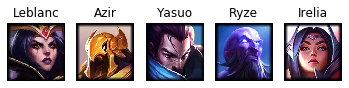

In [6]:
top_ids = [get_champion(c_name=i)['id'] for i in top_cnames]
print(f"Most skillful champions: {top_cnames if in_detail else ''} ")
show_img(img_dir, top_ids)

We find the champions that Faker likes most. Then we want to know the ranking information of Faker and the situation of that league.

Local data loaded. 
Current patch best champion: Irelia 


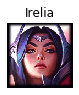

Irelia's current average winning ratio in GRANDMASTER: 
46.53%. 


In [7]:
league = rec.riot.get_leagues(platform, sid)[0]
tier, rank = league['tier'], league['rank']
# use opgg data manager to retrieve champion ranking data
champion_ranks = rec.opgg.get_champion_ranks(
    data_save_path+f'/{tier.lower()}.json', tier.lower(), source)
top_champions_dic = {i: {} for i in top_cnames}
for c_name, c_body in champion_ranks.items():
    if c_name in top_cnames:
        top_champions_dic[c_name]['rank'] = c_body['rank']
        top_champions_dic[c_name]['win_ratio'] = c_body['win_ratio']
# get champion recommendation
best_c = max(
    top_champions_dic.items(), key=lambda x: x[1]['rank'])[0]
print(f"Current patch best champion: {best_c if in_detail else ''} ")
show_img(img_dir, get_champion(c_name=best_c)['id'])
print(f"{best_c}'s current average winning ratio in {tier}: ")
print(f"{top_champions_dic[best_c]['win_ratio']}. ")

We find that Faker is living a hard life in Grandmasters. So what's the Pros and Cons of his favorite? We want the counters.

For different positions: 
Local data loaded. 
[Position top]: 
Irelia is countered by: 
{'Nasus': '38.17%', 'Warwick': '38.46%', "Cho'Gath": '38.57%'}


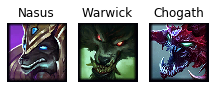

Besides, Irelia performs well against: 
{'Sylas': '65.15%', 'Pantheon': '56.20%', 'Yorick': '55.12%'}


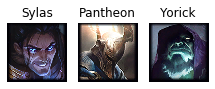

[Position middle]: 
Irelia is countered by: 
{'Volibear': '32.31%', 'Diana': '43.37%', 'Jax': '43.95%'}


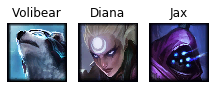

Besides, Irelia performs well against: 
{'Cassiopeia': '62.96%', 'Pantheon': '62.32%', 'Vladimir': '60.84%'}


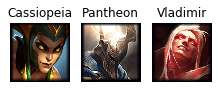

In [8]:
print("For different positions: ")
counters_data = rec.opgg.get_champion_counters(best_c, source)
for pos in counters_data:
    print(f"[Position {pos}]: ")
    print(f"{best_c} is countered by: ")
    strongs = counters_data[pos]['strong']
    print(strongs if in_detail else '')
    strongs = [
        get_champion(c_name=i)['id'] for i in list(strongs.keys())]
    show_img(img_dir, strongs)

    print(f"Besides, {best_c} performs well against: ")
    weaks = counters_data[pos]['weak'] 
    print(weaks if in_detail else '')
    weaks = [
        get_champion(c_name=i)['id'] for i in list(weaks.keys())]
    show_img(img_dir, weaks)

Apart from the favorite one, Faker can try other OP champions currently in his league.

Also, Hide on bush can try champions with high winning ratios: 
[('Ziggs', {'rank': '1', 'win_ratio': '100.00%'}), ('Veigar', {'rank': '2', 'win_ratio': '85.29%'}), ('Ashe', {'rank': '3', 'win_ratio': '80.00%'}), ('Nasus', {'rank': '4', 'win_ratio': '80.00%'}), ('Fiddlesticks', {'rank': '5', 'win_ratio': '78.57%'})]


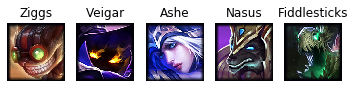

In [9]:
op_champions = sorted(
    champion_ranks.items(), key=lambda x: int(x[1]['rank']))[:5]
print(f"Also, {sname} can try champions with high winning ratios: ")
print(op_champions if in_detail else '')
show_img(
    img_dir,
    [get_champion(c_name=cp)['id'] for cp, data in op_champions])

That's almost the details of the first part: for rank players. So sad there is no more time to add items and perks details...

Below is an example of the encapsulated function.

Connection test passed. 
Local data loaded. 
Summoner name: The shy, Rank: DIAMOND IV
Most skillful champions:  


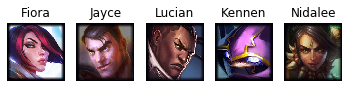

Current patch best champion:  


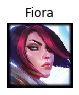

Fiora's current average winning ratio in DIAMOND: 
51.11%. 
For different positions: 
Local data loaded. 
[Position top]: 
Fiora is countered by: 



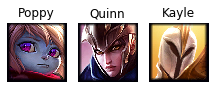

Besides, Fiora performs well against: 



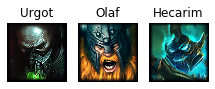

Also, The shy can try champions with high winning ratios: 



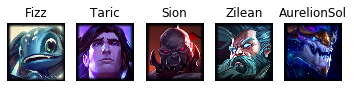

In [10]:
# rec.recommend_for_ranks(platform='KR', sname='The shy', in_detail=True, source='local')
rec.recommend_for_ranks(platform='KR', sname='The shy', in_detail=False, source='local')

2. **Team Recommendation**

In this part, I want to give some suggestions to teams, especially the professinal ones. These information might help them understand current professional matches and the key winning factors.

Let's say we want some data from representative matches or tournaments. Then the world championship must be the best one. Those data are available on wanplus.com. Also you can choose other events with corresponding 'eid'. You can find the 'eid's in `/data/constants/wanplusEvents.json`

Data are stored as JSON files, but for better representation, I use Pandas DataFrame here.

For the factors of teams, we get preprocessed DataFrame first.

In [12]:
pre_team_df = rec.wanplus.get_team_data(eid='870', source='local')
pre_team_df

Local data loaded. 


win_rate  kills/game  deaths/game  assists/game  total_heroes  \
FPX  0.777778        18.6         11.1       42.0556          31.0   
GRF  0.636364        15.5          9.5       36.5455          28.0   
RNG  0.500000        13.0         10.5       31.0000          18.0   
DWG  0.600000        13.9         11.5       32.6000          23.0   
SKT  0.642857        15.5         12.3       32.5000          34.0   
FNC  0.500000        13.7         15.1       32.4000          24.0   
SPY  0.454545        12.2         12.8       26.6364          31.0   
IG   0.571429        14.9         16.2       32.7857          31.0   
JT   0.500000        11.8         13.5       26.3333          20.0   
G2   0.611111        13.4         14.4       26.1667          37.0   
TL   0.500000        10.8         14.2       25.0000          17.0   
AHQ  0.000000         7.5         12.2       17.3333          20.0   
HKA  0.000000         9.2         13.8       17.5000          20.0   
C9   0.333333        11.0         20.0       22.5000          23.0   
CG   0.000000         9.7         18.2       20.6667          24.0   
GAM  0.166667         9.2         16.2       16.5000          19.0   

     avg_time/game  1stblood_rate  1stblood_winrate  wards/min  \
FPX         1875.0          0.667          0.750000       4.00   
GRF         1973.0          0.636          0.714286       4.23   
RNG         2080.0          0.500          0.333333       4.35   
DWG         1985.0          0.300          1.000000       4.07   
SKT         1974.0          0.643          0.666667       4.43   
FNC         1995.0          0.500          0.600000       3.49   
SPY         1992.0          0.364          0.750000       3.74   
IG          1983.0          0.286          0.500000       3.61   
JT          1995.0          0.333          0.500000       4.11   
G2          1932.0          0.667          0.750000       4.09   
TL          1942.0          0.500          0.666667       3.37   
AHQ         1923.0          0.667          0.000000       3.67   
HKA         2032.0          0.667          0.000000       3.45   
C9          1989.0          0.167          1.000000       3.61   
CG          2080.0          0.333          0.000000       3.86   
GAM         1817.0          0.333          0.000000       3.14   

     wards_killed/min  wards_killed_rate  dragons/game  dragon_rate  \
FPX               1.6              0.420           2.9        0.703   
GRF               1.8              0.491           3.0        0.673   
RNG               2.0              0.492           2.5        0.517   
DWG               1.7              0.428           2.9        0.630   
SKT               1.8              0.444           3.1        0.667   
FNC               1.6              0.405           1.8        0.391   
SPY               1.7              0.419           1.7        0.396   
IG                1.7              0.435           1.9        0.429   
JT                1.3              0.387           1.8        0.458   
G2                1.8              0.434           2.1        0.462   
TL                1.7              0.454           2.3        0.538   
AHQ               1.5              0.431           1.0        0.231   
HKA               1.2              0.337           1.0        0.231   
C9                1.4              0.374           1.7        0.435   
CG                1.9              0.476           1.8        0.355   
GAM               1.6              0.389           1.2        0.333   

     barons/game  baron_rate  1stbaron_win_rate  towers/game  \
FPX          1.0       0.750           1.000000          7.8   
GRF          0.7       0.533           1.000000          7.4   
RNG          0.8       0.500           0.750000          7.2   
DWG          0.9       0.692           1.000000          6.7   
SKT          1.1       0.696           0.700000          7.6   
FNC          0.7       0.500           1.000000          6.1   
SPY          0.6       0.438       

Then standardize it.

In [13]:
std_team_df = get_std_df(pre_team_df)
std_team_df

win_rate  kills/game  deaths/game  assists/game  total_heroes  \
0   1.454135    2.177946    -1.004561      2.052438      1.000000   
1   0.871843    1.072254    -1.590364      1.280372      0.500000   
2   0.310345    0.180567    -1.224237      0.503347     -1.166667   
3   0.722109    0.501574    -0.858110      0.727536     -0.333333   
4   0.898579    1.072254    -0.565209      0.713524      1.500000   
5   0.310345    0.430239     0.459947      0.699512     -0.166667   
6   0.123178   -0.104773    -0.382145     -0.108073      1.000000   
7   0.604464    0.858249     0.862687      0.753556      1.000000   
8   0.310345   -0.247443    -0.125856     -0.150543     -0.833333   
9   0.767860    0.323237     0.203658     -0.173887      2.000000   
10  0.310345   -0.604118     0.130433     -0.337363     -1.333333   
11 -1.748474   -1.781145    -0.601821     -1.411607     -0.833333   
12 -1.748474   -1.174798    -0.016018     -1.388250     -0.833333   
13 -0.375929   -0.532783     2.253969     -0.687658     -0.333333   
14 -1.748474   -0.996460     1.594941     -0.944537     -0.166667   
15 -1.062200   -1.174798     0.862687     -1.528368     -1.000000   

    avg_time/game  1stblood_rate  1stblood_winrate  wards/min  \
0       -1.510187       1.175208          0.697796   0.479393   
1        0.000964       0.987719          0.592003   1.113985   
2        1.650894       0.165187         -0.536462   1.445077   
3        0.186003      -1.044419          1.438350   0.672530   
4        0.016384       1.030055          0.450945   1.665804   
5        0.340202       0.165187          0.253463  -0.927746   
6        0.293942      -0.657345          0.697796  -0.237972   
7        0.155163      -1.129092         -0.042758  -0.596655   
8        0.340202      -0.844834         -0.042758   0.782894   
9       -0.631252       1.175208          0.697796   0.727712   
10      -0.477053       0.165187          0.450945  -1.258838   
11      -0.770032       1.175208         -1.523867  -0.431109   
12       0.910738       1.175208         -1.523867  -1.038110   
13       0.247682      -1.848807          1.438350  -0.596655   
14       1.650894      -0.844834         -1.523867   0.093120   
15      -2.404541      -0.844834         -1.523867  -1.893430   

    wards_killed/min  wards_killed_rate  dragons/game  dragon_rate  \
0          -0.212316          -0.147699      1.285436     1.659621   
1           0.758272           1.600068      1.435560     1.449930   
2           1.728861           1.624685      0.684940     0.359534   
3           0.272978           0.049233      1.285436     1.149372   
4           0.758272           0.443096      1.585684     1.407991   
5          -0.212316          -0.516945     -0.365927    -0.521171   
6           0.272978          -0.172315     -0.516051    -0.486222   
7           0.272978           0.221548     -0.215803    -0.255562   
8          -1.668199          -0.960041     -0.365927    -0.052860   
9           0.758272           0.196931      0.084445    -0.024901   
10          0.272978           0.689260      0.384693     0.506318   
11         -0.697611           0.123082     -1.566919    -1.639526   
12         -2.153494          -2.190863     -1.566919    -1.639526   
13         -1.182905          -1.280055     -0.516051    -0.213623   
14          1.243567           1.230822     -0.365927    -0.772801   
15         -0.212316          -0.910808     -1.266671    -0.926575   

    barons/game  baron_rate  1stbaron_win_rate  towers/game  towers_lost/game  \
0      1.258251    1.372489           0.784631     1.251309         -1.545650   
1      0.284121    0.398392           0.784631     1.022499         -1.202965   
2      0.608831    0.250258           0.180238     0.908093         -0.460482   
3      0.933541    1.112131           0.784631     0.622080         -0.917395   
4      1.582961    1.130087           0.059360     1.136904         -0.803167   
5      0.284121    0.250258           0.784631 

Then get the key factors.

In [14]:
team_keys = get_key_factors(std_team_df, 'win_rate')
team_keys

kills/game           0.964384
assists/game         0.948453
1stblood_winrate     0.845380
dragons/game         0.873882
dragon_rate          0.918583
barons/game          0.904782
baron_rate           0.916740
1stbaron_win_rate    0.977033
towers/game          1.027795
1sttower_win_rate    0.937840
Name: win_rate, dtype: float64

Show percentages of each factor.

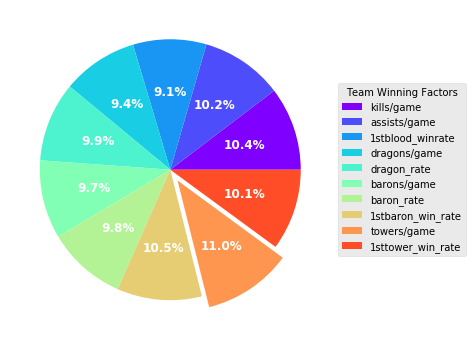

In [15]:
pie_factors(team_keys, 'Team Winning Factors')

We can notice that 'League of Legends if a game focus on resources' is true. Towers is the 1st winning factor for a team in the world championship. Other resources are dragons and barons. Another important thing is that how well the team makes use of the resource-lead weights much in these factors, showing that if one team can do well on the snowball effect when they lead, they will probably win.

Same process for each player position.

In [17]:
pre_player_df = rec.wanplus.get_player_data(eid='870', pos='MID', source='local')
pre_player_df

Local data loaded. 
Local data loaded. 


win_rate  heronum  kills/game  deaths/game  asts/game  golds/min  \
Doinb      0.777778      8.0         4.4          2.0        8.7      430.0   
Caps       0.611111     10.0         3.3          2.6        5.3      408.0   
Faker      0.642857     10.0         3.6          2.4        5.5      426.0   
Rookie     0.571429      8.0         3.9          2.6        7.1      397.0   
Chovy      0.636364      8.0         2.7          1.5        6.0      394.0   
Humanoid   0.454545      6.0         3.0          3.5        3.8      408.0   
ShowMaker  0.600000      6.0         3.7          1.4        5.5      412.0   
Nemesis    0.500000      6.0         2.6          2.2        6.0      411.0   
Jensen     0.500000      4.0         2.5          2.7        4.0      383.0   
Xiaohu     0.500000      4.0         2.5          1.7        5.5      389.0   
M1ssion    0.000000      5.0         2.2          2.8        2.0      377.0   
FoFo       0.500000      5.0         3.7          2.5        4.2      407.0   
Nisqy      0.333333      6.0         1.7          4.2        4.3      358.0   
Damonte    0.000000      5.0         2.0          3.2        3.3      370.0   
Kiaya      0.166667      4.0         2.7          2.8        3.0      377.0   
Rainbow    0.000000      4.0         2.8          2.4        2.8      342.0   
Apex       0.000000      1.0         1.0          1.0        1.0      343.0   

           lasthit/min  golds_rate  dmg_taken/min  dmg/min  dmg_taken_rate  \
Doinb             8.51    0.222691          565.0    501.0           0.207   
Caps              8.51    0.222332          483.0    421.0           0.195   
Faker             8.80    0.222530          458.0    403.0           0.182   
Rookie            7.91    0.218528          484.0    534.0           0.179   
Chovy             8.63    0.210988          573.0    460.0           0.220   
Humanoid          9.19    0.227112          489.0    432.0           0.203   
ShowMaker         8.67    0.220404          365.0    343.0           0.152   
Nemesis           8.75    0.224066          537.0    486.0           0.183   
Jensen            8.36    0.218766          495.0    373.0           0.190   
Xiaohu            8.46    0.208764          382.0    318.0           0.158   
M1ssion           8.81    0.226858          382.0    316.0           0.136   
FoFo              8.87    0.231860          446.0    572.0           0.180   
Nisqy             7.42    0.205220          572.0    393.0           0.171   
Damonte           8.47    0.218735          462.0    461.0           0.179   
Kiaya             8.51    0.220808          625.0    317.0           0.221   
Rainbow           7.18    0.211654          471.0    387.0           0.185   
Apex              9.19    0.232285          256.0    403.0           0.092   

           dmg_rate  attend_rate  dmg/golds  wards/min  wards_killed/min  \
Doinb         0.257        0.704   1.164400       0.43              0.24   
Caps          0.248        0.640   1.031130       0.43              0.18   
Faker         0.227        0.590   0.944615       0.54              0.28   
Rookie        0.261        0.737   1.343140       0.37              0.32   
Chovy         0.223        0.561   1.168240       0.48              0.40   
Humanoid      0.264        0.560   1.058200       0.47              0.22   
ShowMaker     0.215        0.662   0.833020       0.49              0.28   
Nemesis       0.256        0.628   1.180850       0.46              0.25   
Jensen        0.227        0.600   0.972972       0.34              0.20   
Xiaohu        0.200        0.615   0.817427       0.37              0.38   
M1ssion       0.194        0.455   0.838769       0.37              0.22   
FoFo          0.306        0.662   1.404640       0.34              0.21   
Nisqy         0.190        0.545   1.097650       0.43              0.22   
Damonte       0.237        0.552   1.245040       0.47              0.18   
Kiaya         0.235        0.618   0.840577

In [18]:
std_player_df = get_std_df(pre_player_df)
std_player_df

win_rate   heronum  kills/game  deaths/game  asts/game  golds/min  \
0   1.477539  0.932005    1.856828    -0.574616   2.219238   1.557440   
1   0.826283  1.812231    0.546538     0.206862   0.384160   0.698321   
2   0.950331  1.812231    0.903890    -0.053631   0.492106   1.401237   
3   0.671224  0.932005    1.261242     0.206862   1.355672   0.268762   
4   0.924960  0.932005   -0.168166    -1.225847   0.761970   0.151609   
5   0.214496  0.051778    0.189186     1.379078  -0.425433   0.698321   
6   0.782866  0.051778    1.023007    -1.356093   0.492106   0.854525   
7   0.392113  0.051778   -0.287283    -0.314123   0.761970   0.815474   
8   0.392113 -0.828449   -0.406400     0.337108  -0.317488  -0.277950   
9   0.392113 -0.828449   -0.406400    -0.965354   0.492106  -0.043645   
10 -1.561653 -0.388335   -0.763752     0.467354  -1.396945  -0.512255   
11  0.392113 -0.388335    1.023007     0.076615  -0.209542   0.659270   
12 -0.259144  0.051778   -1.359338     2.290801  -0.155569  -1.254222   
13 -1.561653 -0.388335   -1.001986     0.988339  -0.695298  -0.785611   
14 -0.910396 -0.828449   -0.168166     0.467354  -0.857216  -0.512255   
15 -1.561653 -0.828449   -0.049048    -0.053631  -0.965162  -1.879035   
16 -1.561653 -2.148789   -2.193159    -1.877078  -1.936674  -1.839984   

    lasthit/min  golds_rate  dmg_taken/min   dmg/min  dmg_taken_rate  \
0      0.048318    0.335964       1.038173  1.112344        0.935079   
1      0.048318    0.287314       0.110472  0.029461        0.542577   
2      0.602285    0.314146      -0.172363 -0.214188        0.117366   
3     -1.097822   -0.228182       0.121786  1.559033        0.019240   
4      0.277546   -1.249960       1.128681  0.557366        1.360290   
5      1.347276    0.935073       0.178353  0.178357        0.804245   
6      0.353955    0.026043      -1.224512 -1.026350       -0.863890   
7      0.506774    0.522296       0.721397  0.909303        0.150074   
8     -0.238217   -0.195930       0.246233 -0.620269        0.379034   
9     -0.047194   -1.551344      -1.032184 -1.364751       -0.667639   
10     0.621388    0.900652      -1.032184 -1.391823       -1.387226   
11     0.736002    1.578495      -0.308125  2.073402        0.051949   
12    -2.033836   -2.031607       1.117368 -0.349548       -0.242428   
13    -0.028092   -0.200131      -0.127110  0.570902        0.019240   
14     0.048318    0.080790       1.716979 -1.378287        1.392998   
15    -2.492292   -1.159708      -0.025289 -0.430764        0.215491   
16     1.347276    1.636088      -2.457676 -0.214188       -2.826401   

    dmg_rate  attend_rate  dmg/golds  wards/min  wards_killed/min  \
0   0.508375     0.624909   0.522134  -0.275149         -0.160752   
1   0.230585     0.052602  -0.242534  -0.275149         -1.023734   
2  -0.417594    -0.394513  -0.738935   0.979800          0.414570   
3   0.631838     0.920005   1.547698  -0.959667          0.989892   
4  -0.541057    -0.653840   0.544167   0.295282          2.140535   
5   0.724435    -0.662782  -0.087214   0.181196         -0.448412   
6  -0.787982     0.249332  -1.379238   0.409368          0.414570   
7   0.477510    -0.054706   0.616520   0.067110         -0.016921   
8  -0.417594    -0.305090  -0.576230  -1.301925         -0.736073   
9  -1.250967    -0.170956  -1.468707  -0.959667          1.852874   
10 -1.436161    -1.601724  -1.346252  -0.959667         -0.448412   
11  2.020793     0.249332   1.900569  -1.301925         -0.592243   
12 -1.559623    -0.796917   0.139140  -0.275149         -0.448412   
13 -0.108938    -0.734321   0.984826   0.181196         -1.023734   
14 -0.170669    -0.144129  -1.335878   0.637541          1.277552   
15  0.076256     0.150967   0.336691   2.919266         -1.023734   
16  2.020793     3.271829   0.583241   0.637541         -1.167565   

    lasthit_lead/game  golds_lead/game  
0            0.936875         1.383970  
1            0.772867         0.802453  
2            1.041402     

In [19]:
player_keys = get_key_factors(std_player_df, 'win_rate')
player_keys

heronum              0.747340
kills/game           0.770048
asts/game            0.929854
golds/min            0.901713
lasthit_lead/game    0.846988
golds_lead/game      0.950714
Name: win_rate, dtype: float64

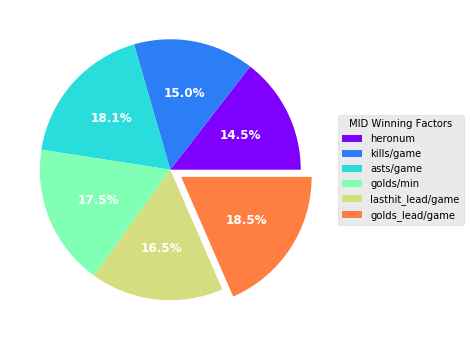

In [20]:
pie_factors(player_keys, 'MID Winning Factors')

As a MID lane player, one should consider and do well on multiple aspects like being familiar with more champions, balance kills and assists, while also focusing on the economy. Oh, that's pretty tough, hope other positions are easier.

That's almost the details of the second part: for teams.

Below is an example of the encapsulated function.

The winning factors will be listed according to event 870. 
Local data loaded. 
The weights of team factors related to winning: 
                   win_rate
kills/game         0.964384
assists/game       0.948453
1stblood_winrate   0.845380
dragons/game       0.873882
dragon_rate        0.918583
barons/game        0.904782
baron_rate         0.916740
1stbaron_win_rate  0.977033
towers/game        1.027795
1sttower_win_rate  0.937840


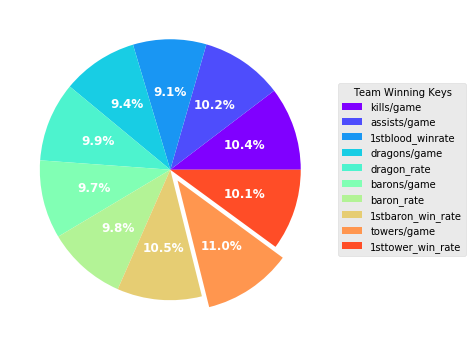

Local data loaded. 
Local data loaded. 
The weights of position TOP factors related to winning: 
                 win_rate
asts/game        0.792378
golds_lead/game  0.791720


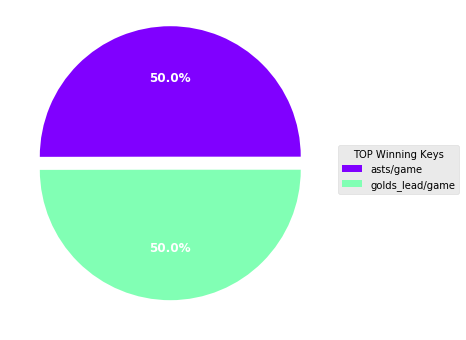

Local data loaded. 
Local data loaded. 
The weights of position JUG factors related to winning: 
                 win_rate
asts/game        0.871746
golds_lead/game  0.719027


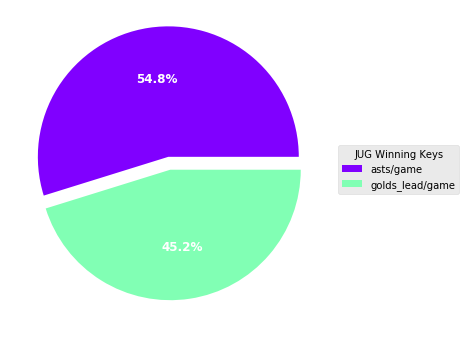

Local data loaded. 
Local data loaded. 
The weights of position MID factors related to winning: 
                   win_rate
heronum            0.747340
kills/game         0.770048
asts/game          0.929854
golds/min          0.901713
lasthit_lead/game  0.846988
golds_lead/game    0.950714


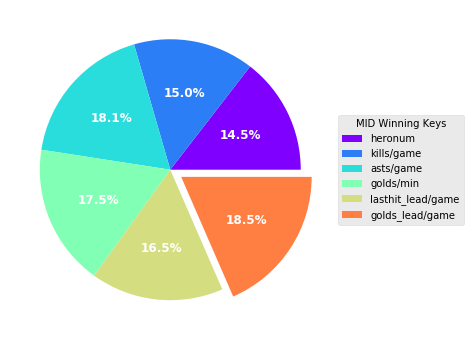

Local data loaded. 
Local data loaded. 
The weights of position BOT factors related to winning: 
                 win_rate
kills/game       0.913432
golds/min        0.925284
golds_lead/game  0.853776


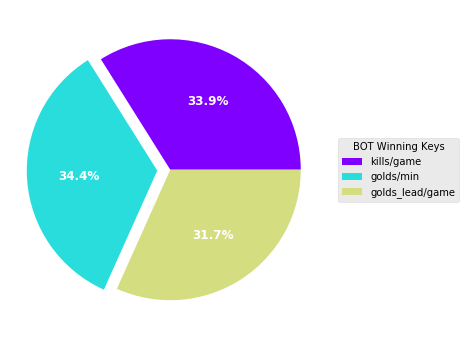

Local data loaded. 
Local data loaded. 
The weights of position SUP factors related to winning: 
                 win_rate
asts/game        0.822767
golds_lead/game  0.724297


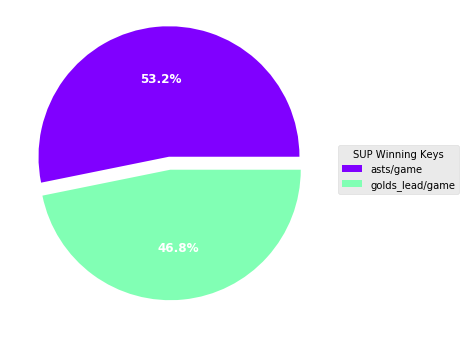

The factors above are important and worth paying attention.


In [21]:
rec.recommend_for_teams(eid='870', source='local')

Even though this is not perfect, I put much effort into it, and I really had fun. Hope I can add more interesting parts to it in the future.

7. **What difficulties did you have in completing the project?**  

    Actually there are not much technical trouble, the most difficult thing is creativity. That is, how to explore the data and how to combine different types of data and then get the satisfying result I want and I paid much to thinking about that. By the way, if I found the secret of winning League of Legends so easily, the gamers will not fun.

8. **What skills did you wish you had while you were doing the project?**

    They must be the plots. Without much experience using matplotlib, I found it time-consuming to arrange the elements of a plot, especially the ones with subplots. If I had more experience of that, I can plot the graphs much better and faster.

9. **What would you do “next” to expand or augment the project?**

    The first thing is to add items and perks (both are important parts of League of Legends games) to rank recommendation, which can increase the accuracy of my recommendation and help the players more.
    
    Second, game factors should be exploited more, more detailed analyses should be done with some unused data.
    
    Third, the visualization part should be improved. If I had better plotting skills, I would do it as well as I can.